##  Feature Selection

In [59]:
!pip install rdkit deap scikit-learn

In [60]:
!pip install mordred

In [19]:
pip install "numpy<1.24"

Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import pandas as pd
import random

from rdkit import Chem
from rdkit.Chem import Descriptors, Draw

from deap import base, creator, tools, algorithms

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import seaborn as sns

Load and Preprocess Molecular Data

In [62]:
# data = pd.read_csv("/content/bace1_bioactivity_data_curated.csv")


data = pd.read_csv("bace1_bioactivity_data_curated.csv")
# data = data1.head(10)

In [63]:
data.head()


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,active
1,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,active
2,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,active
3,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,inactive
4,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,inactive


In [64]:
data.shape

(7459, 4)

Getting all RDKit molecular descriptor names and Function to compute molecular descriptors

In [65]:
# descriptor_names = [desc[0] for desc in Descriptors.descList]

# def compute_descriptors(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         print([0])
#         return [0] * len(descriptor_names)  # Handle invalid molecules
#     return [Descriptors.__dict__[name](mol) for name in descriptor_names]

In [66]:
print([0])
descriptor_names = [desc[0] for desc in Descriptors.descList]
print(len(descriptor_names))

[0]
217


In [67]:
descriptor_names

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',


In [68]:
data.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'class'], dtype='object')

## Calculating Descriptor Using Mordred

In [69]:
from mordred import Calculator, descriptors

mol_list = []

for smile in data['canonical_smiles']:
  mol = Chem.MolFromSmiles(smile)
  mol = Chem.AddHs(mol)
  mol_list.append(mol)

df = pd.concat([data, pd.DataFrame(mol_list, columns = (['Mol']))], axis=1)

In [70]:
df.head()


,molecule_chembl_id,canonical_smiles,standard_value,class,Mol
0,CHEMBL406146,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,413.0,active,<rdkit.Chem.rdchem.Mol object at 0x787ff259c820>
1,CHEMBL78946,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,2.0,active,<rdkit.Chem.rdchem.Mol object at 0x787ff259c660>
2,CHEMBL324109,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,460.0,active,<rdkit.Chem.rdchem.Mol object at 0x787ff259c6d0>
3,CHEMBL114147,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,9000.0,inactive,<rdkit.Chem.rdchem.Mol object at 0x787ff259c740>
4,CHEMBL419949,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5600.0,inactive,<rdkit.Chem.rdchem.Mol object at 0x787ff259c7b0>


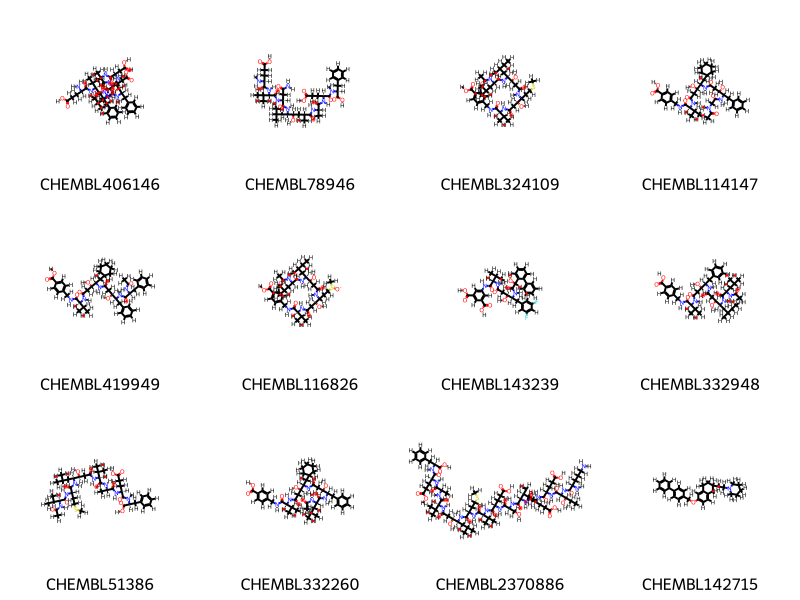

In [71]:

Draw.MolsToGridImage(df['Mol'][:12],molsPerRow=4,subImgSize=(200,200),legends=[x for x in df['molecule_chembl_id'][:12]])


In [72]:
# Creating a descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

In [73]:
calc


In [74]:
# calc.descriptors contains all the descriptor classes
print(calc.descriptors[:5])

(mordred.ABCIndex.ABCIndex(), mordred.ABCIndex.ABCGGIndex(), mordred.AcidBase.AcidicGroupCount(), mordred.AcidBase.BasicGroupCount(), mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'))


In [75]:
# print the names of descriptors
all_descriptor_names = [desc.__class__.__name__ for desc in calc.descriptors]
print(all_descriptor_names[:20])

['ABCIndex', 'ABCGGIndex', 'AcidicGroupCount', 'BasicGroupCount', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AromaticAtomsCount', 'AromaticBondsCount', 'AtomCount', 'AtomCount']


In [76]:
# Checking the length of descriptors in the calculator
len(all_descriptor_names)

1613

In [ ]:
all_desc = calc.pandas(df['Mol'])

In [57]:
all_desc.head(12)

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,52.913863,42.915511,4,1,84.986268,2.357398,4.714795,84.986268,1.19699,5.133486,...,10.820278,110.064076,998.459678,7.288027,28854,104,338.0,376.0,30.916667,15.944444
1,46.590342,38.520706,3,1,74.01907,2.337816,4.675632,74.01907,1.174906,5.006706,...,10.667023,101.362551,892.454199,7.027198,22054,91,296.0,327.0,29.194444,14.166667
2,38.167759,31.380885,1,0,61.659032,2.315876,4.631753,61.659032,1.185751,4.814306,...,10.458665,89.340175,751.419000,6.649726,13123,74,242.0,267.0,23.388889,11.916667
3,40.001350,30.729173,1,0,65.429866,2.323173,4.646345,65.429866,1.234526,4.8547,...,10.531856,90.661269,737.399978,6.827778,13440,75,256.0,285.0,20.027778,11.888889
4,45.617764,34.511984,1,0,74.831685,2.33544,4.67088,74.831685,1.247195,4.985373,...,10.699124,98.407890,827.446929,6.838404,18407,87,294.0,330.0,21.5,13.416667
5,39.093645,32.103470,1,0,62.396469,2.316859,4.633718,62.396469,1.177292,4.834247,...,10.480859,90.459140,767.413914,6.731701,13668,75,248.0,273.0,24.25,12.000000
6,39.948979,31.253555,2,0,64.272272,2.402521,4.805041,64.272272,1.236005,4.854123,...,10.748519,90.157534,717.249786,8.058986,11793,83,264.0,304.0,20.111111,11.416667
7,40.996186,32.847953,1,0,66.095102,2.325627,4.651253,66.095102,1.201729,4.881479,...,10.561085,92.784459,767.446929,6.615922,14766,79,262.0,291.0,23.25,12.416667
8,45.664455,38.037591,2,0,73.121471,2.332258,4.664517,73.121471,1.179379,4.989955,...,10.655729,100.273284,893.456842,6.926022,20917,90,290.0,321.0,28.333333,14.083333
9,43.008117,33.445037,1,0,69.60563,2.331172,4.662345,69.60563,1.221151,4.926508,...,10.625927,95.070348,793.462579,6.612188,16074,82,276.0,308.0,22.25,12.750000


In [52]:
all_desc.to_csv('BACE1_All_Descriptors.csv', index=False)

In [55]:
df_merged = pd.concat([data, all_desc], axis=1, ignore_index=False)


In [56]:
df_merged.to_csv('BACE1_Merged_Data_and_Descriptors.csv', index=False)


In [14]:
# from mordred import Calculator, descriptors

# mol_list = []

# calc = Calculator(descriptors, ignore_3D=True)

# def compute_mordred_descriptors(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     mol = Chem.AddHs(mol)
#     mol_list.append(mol)

#     if mol is None:
#         return None
#             # Handle invalid molecules
#     m = calc(mol)
#     print(m)
#     return m

In [27]:
print(data["canonical_smiles"].dtype)

object


In [97]:
all_desc = pd.read_csv("/home/bio/Bio thesis cse20/CD-232/Drug-Discovery-main/BACE1_All_Descriptors.csv")

/tmp/ipykernel_2991605/3218517920.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,53,54,55,56,57,58,59,60,61,141,142,150,151,152,153,154,155,156,157,158,159,160,168,169,177,178,186,187,195,196,204,205,213,214,222,223,231,232,233,234,235,236,237,238,239,240,241,260,261,262,263,264,265,266,267,268,341,342,343,344,345,346,347,348,349,357,358,366,367,368,369,370,371,372,373,374,375,376,384,385,393,394,402,403,411,412,420,421,429,430,438,439,447,448,449,450,451,452,453,454,455,456,463,464,471,472,473,474,475,476,477,478,479,480,487,488,495,496,503,504,511,512,519,520,527,528,535,536,543,544,545,546,547,548,549,550,551,552,559,560,567,568,569,570,571,572,573,574,575,576,583,584,591,592,599,600,607,608,615,616,623,624,631,632,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,

In [98]:
print(all_desc.describe())

               ABC        ABCGG        nAcid        nBase    nAromAtom  \
count  7459.000000  7459.000000  7459.000000  7459.000000  7459.000000   
mean     25.928064    20.337453     0.109130     1.614291    13.750637   
std       7.865126     5.956283     0.526219     1.030594     5.389871   
min       5.875634     5.525875     0.000000     0.000000     0.000000   
25%      21.735933    17.366659     0.000000     1.000000    12.000000   
50%      24.587803    19.389858     0.000000     2.000000    12.000000   
75%      28.381731    21.729403     0.000000     2.000000    18.000000   
max     166.444603   113.447308     7.000000     8.000000    47.000000   

         nAromBond        nAtom   nHeavyAtom       nSpiro  nBridgehead  ...  \
count  7459.000000  7459.000000  7459.000000  7459.000000  7459.000000  ...   
mean     13.892479    60.031103    33.178040     0.374983     0.086741  ...   
std       5.545126    23.268020    10.662247     0.737111     0.560963  ...   
min       0.00000

In [136]:
# Generate the summary statistics using describe()
desc = all_desc.describe()

# Access the 'max' row and print it
max_values = desc.loc['max']

print("Max values for each column:")
print(max_values.max())


Max values for each column:
35000010828.0


In [99]:
nan_positions = np.where(all_desc.isna())  # Get row, col indices of NaNs
nan_rows_list = nan_positions[0]  # Row indices
nan_cols_list = all_desc.columns[nan_positions[1]]  # Column names

# Print NaN locations
for row, col in zip(nan_rows_list, nan_cols_list):
    print(f"NaN found at Row {row}, Column '{col}'")


NaN found at Row 7349, Column 'VR1_A'
NaN found at Row 7349, Column 'VR2_A'
NaN found at Row 7349, Column 'VR3_A'


In [101]:
print(all_desc.loc[7349, ['VR1_A', 'VR2_A', 'VR3_A', 'VE2_A']])


VR1_A                     NaN
VR2_A                     NaN
VR3_A                     NaN
VE2_A    0.021492563458053858
Name: 7349, dtype: object


In [102]:
# all_desc = all_desc.drop(index=7349)
all_desc.fillna(0, inplace=True)  # Replace NaNs with 0 in the original DataFrame


In [ ]:
print("NaN in desc:", all_desc.isna().sum().sum())  # Count total NaNs
print("Max value in desc:", all_desc.max().max())  # Get overall max value
print("Min value in desc:", all_desc.min(axis=1).min())  # Get overall min value


In [107]:
print("Max value in desc:", all_desc.to_numpy().max())  # Get overall max value
print("Min value in desc:", all_desc.to_numpy().min()) 

TypeError: '>=' not supported between instances of 'float' and 'str'

In [ ]:
non_numeric_columns = all_desc.select_dtypes(exclude=['number']).columns

print("Columns with non-numeric data:")
print(non_numeric_columns)

Columns with non-numeric data:
Index(['SpAbs_A', 'SpMax_A', 'SpDiam_A', 'SpAD_A', 'SpMAD_A', 'LogEE_A',
       'VE1_A', 'VE2_A', 'VE3_A', 'VR1_A',
       ...
       'MID_C', 'AMID_C', 'MID_N', 'AMID_N', 'MID_O', 'AMID_O', 'MID_X',
       'AMID_X', 'Vabc', 'mZagreb1'],
      dtype='object', length=576)


In [133]:
# Find all rows containing non-numeric values in any column

non_numeric_rows = all_desc[all_desc.applymap(lambda x: isinstance(x, ( bool, int, float)) or pd.isna(x))]

print("Rows with non-numeric values:")
print(non_numeric_rows)


/tmp/ipykernel_2991605/2518698632.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_rows = all_desc[all_desc.applymap(lambda x: isinstance(x, ( bool, int, float)) or pd.isna(x))]


Rows with non-numeric values:
            ABC      ABCGG  nAcid  nBase SpAbs_A SpMax_A SpDiam_A SpAD_A  \
0     52.913863  42.915511      4      1     NaN     NaN      NaN    NaN   
1     46.590342  38.520706      3      1     NaN     NaN      NaN    NaN   
2     38.167759  31.380885      1      0     NaN     NaN      NaN    NaN   
3     40.001350  30.729173      1      0     NaN     NaN      NaN    NaN   
4     45.617764  34.511984      1      0     NaN     NaN      NaN    NaN   
...         ...        ...    ...    ...     ...     ...      ...    ...   
7454  33.656655  22.891133      0      1     NaN     NaN      NaN    NaN   
7455  31.535335  22.317521      0      1     NaN     NaN      NaN    NaN   
7456  32.949549  22.851021      0      1     NaN     NaN      NaN    NaN   
7457  32.242442  22.372162      0      1     NaN     NaN      NaN    NaN   
7458  32.949549  22.851021      0      1     NaN     NaN      NaN    NaN   

     SpMAD_A LogEE_A  ...      SRW10      TSRW10         

In [128]:
all_desc

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,52.913863,42.915511,4,1,84.98626757018828,2.357397720189413,4.714795440378827,84.98626757018828,1.1969896840871588,5.133485579543629,...,10.820278,110.064076,998.459678,7.288027,28854,104,338.0,376.0,30.916666666666668,15.944444
1,46.590342,38.520706,3,1,74.01907011815184,2.3378160261613266,4.675632052322653,74.01907011815184,1.174905874891299,5.006705779847072,...,10.667023,101.362551,892.454199,7.027198,22054,91,296.0,327.0,29.194444444444446,14.166667
2,38.167759,31.380885,1,0,61.6590324778258,2.3158764806213203,4.631752961242641,61.6590324778258,1.185750624573573,4.814306142495711,...,10.458665,89.340175,751.419000,6.649726,13123,74,242.0,267.0,23.38888888888889,11.916667
3,40.001350,30.729173,1,0,65.4298656045141,2.323172693179548,4.646345386359095,65.4298656045141,1.2345257661229077,4.854699529105913,...,10.531856,90.661269,737.399978,6.827778,13440,75,256.0,285.0,20.02777777777778,11.888889
4,45.617764,34.511984,1,0,74.83168516520648,2.335440098684775,4.67088019736955,74.83168516520648,1.2471947527534413,4.985372642376859,...,10.699124,98.407890,827.446929,6.838404,18407,87,294.0,330.0,21.5,13.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,33.656655,22.891133,0,1,56.59673908707246,2.3807463610771067,4.761492722154214,56.59673908707246,1.2862895247061923,4.690836869164231,...,10.539667,81.230254,601.351572,6.608259,7057,71,222.0,255.0,14.534722222222221,9.902778
7455,31.535335,22.317521,0,1,52.61886197882372,2.383281869708689,4.761364997052288,52.61886197882372,1.2833868775322859,4.626007159793486,...,10.519457,78.024556,559.304621,6.820788,5783,68,210.0,243.0,13.784722222222221,9.152778
7456,32.949549,22.851021,0,1,55.18693412749742,2.381116241945856,4.760704714662259,55.18693412749742,1.2834170727324983,4.669690536676091,...,10.532976,80.162768,587.335922,6.674272,6602,70,218.0,251.0,14.284722222222221,9.652778
7457,32.242442,22.372162,0,1,54.05941511274238,2.3818323860121775,4.763664772024354,54.05941511274238,1.287128931255771,4.64808735881653,...,10.526239,79.094215,571.341007,6.567138,6190,69,214.0,247.0,14.034722222222223,9.402778


In [117]:
print(all_desc.iloc[232]["SpAbs_A"])


multiple fragments (SpAbs_A/SpAbs)


In [124]:
# Convert to numeric, and coerce errors to NaN (non-numeric values become NaN)
non_numeric_values = all_desc['SpAbs_A'][pd.to_numeric(all_desc['SpAbs_A'], errors='coerce').isna()].unique()

print("Non-numeric unique values in 'SpAbs_A':")
print(non_numeric_values)


Non-numeric unique values in 'SpAbs_A':
['multiple fragments (SpAbs_A/SpAbs)']


In [125]:

# Select the column that is non-numeric, e.g., 'col2'
non_numeric_values = all_desc[pd.to_numeric(all_desc['SpAbs_A'], errors='coerce').isna()]

print("Non-numeric values in 'col2' and the corresponding rows:")
print(non_numeric_values[['SpAbs_A']])

Non-numeric values in 'col2' and the corresponding rows:
                                 SpAbs_A
232   multiple fragments (SpAbs_A/SpAbs)
235   multiple fragments (SpAbs_A/SpAbs)
238   multiple fragments (SpAbs_A/SpAbs)
240   multiple fragments (SpAbs_A/SpAbs)
243   multiple fragments (SpAbs_A/SpAbs)
...                                  ...
7251  multiple fragments (SpAbs_A/SpAbs)
7252  multiple fragments (SpAbs_A/SpAbs)
7253  multiple fragments (SpAbs_A/SpAbs)
7254  multiple fragments (SpAbs_A/SpAbs)
7255  multiple fragments (SpAbs_A/SpAbs)

[130 rows x 1 columns]


In [122]:
print(all_desc['SpAbs_A'].unique())

['84.98626757018828' '74.01907011815184' '61.6590324778258' ...
 '56.59673908707246' '52.61886197882372' '54.05941511274238']


In [ ]:
# # Find indices of columns (features) that contain NaNs
# nan_columns = np.where(np.isnan(X_).any(axis=0))[0]  # Get column indices

# # print(f"Columns containing NaN values: {nan_columns}")
# print(f"Total affected descriptors: {len(nan_columns)}")


Columns containing NaN values: [   0    1  865  866  867  868  869  870  871  872  873  874  875  876
  877  878 1049 1050 1051 1052 1053 1054 1055 1056 1058 1059 1062 1063
 1064 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078
 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092
 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106
 1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120
 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134
 1135 1137 1138 1141 1142 1143 1145 1146 1147 1148 1149 1150 1151 1152
 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166
 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180
 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194
 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1359 1360
 1361 1362 1365 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377]
Total affected descriptors: 182


In [ ]:
# # Print the exact feature names with NaNs
# nan_feature_names = X_df.columns[nan_columns]
# # print(f"Affected descriptors: {nan_feature_names.tolist()}")


Affected descriptors: [0, 1, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1058, 1059, 1062, 1063, 1064, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1137, 1138, 1141, 1142, 1143, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1

In [138]:
# Step 1: Identify and drop non-numeric columns
numeric_columns = all_desc.select_dtypes(include=['number']).columns
all_desc_numeric = all_desc[numeric_columns]



In [139]:
all_desc_numeric

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,52.913863,42.915511,4,1,12,12,137,71,0,0,...,0.0,10.820278,110.064076,998.459678,7.288027,28854,104,338.0,376.0,15.944444
1,46.590342,38.520706,3,1,6,6,127,63,0,0,...,0.0,10.667023,101.362551,892.454199,7.027198,22054,91,296.0,327.0,14.166667
2,38.167759,31.380885,1,0,6,6,113,52,0,0,...,0.0,10.458665,89.340175,751.419000,6.649726,13123,74,242.0,267.0,11.916667
3,40.001350,30.729173,1,0,12,12,108,53,0,0,...,0.0,10.531856,90.661269,737.399978,6.827778,13440,75,256.0,285.0,11.888889
4,45.617764,34.511984,1,0,18,18,121,60,0,0,...,0.0,10.699124,98.407890,827.446929,6.838404,18407,87,294.0,330.0,13.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7454,33.656655,22.891133,0,1,18,18,91,44,0,4,...,0.0,10.539667,81.230254,601.351572,6.608259,7057,71,222.0,255.0,9.902778
7455,31.535335,22.317521,0,1,18,18,82,41,0,4,...,0.0,10.519457,78.024556,559.304621,6.820788,5783,68,210.0,243.0,9.152778
7456,32.949549,22.851021,0,1,18,18,88,43,0,4,...,0.0,10.532976,80.162768,587.335922,6.674272,6602,70,218.0,251.0,9.652778
7457,32.242442,22.372162,0,1,18,18,87,42,0,4,...,0.0,10.526239,79.094215,571.341007,6.567138,6190,69,214.0,247.0,9.402778


In [140]:
# Step 2: Save the modified DataFrame to a CSV file
all_desc_numeric.to_csv('only_numeric_all_desc.csv', index=False)

print("Modified DataFrame with only numeric columns has been saved to 'cleaned_all_desc.csv'.")


Modified DataFrame with only numeric columns has been saved to 'cleaned_all_desc.csv'.


In [141]:
print("NaN in desc:", all_desc_numeric.isna().sum().sum())  # Count total NaNs


NaN in desc: 0


## Feature Selection: Remove Low-Variance and Correlated Features

In [145]:
import pandas as pd

# Step 1: Remove Low-Variance Features
# Calculate variance for each feature
variances = all_desc_numeric.var()

# Define a threshold for low variance, for example, 0.1
low_variance_features = variances[variances < 0.1].index

# Remove low variance features from the DataFrame
all_desc_filtered_low_variance = all_desc_numeric.drop(columns=low_variance_features)

print(f"Removed low-variance features: {low_variance_features.tolist()}")
print("Data after removing low-variance features:")
print(all_desc_filtered_low_variance)

# Step 2: Remove Highly Correlated Features
# Compute the correlation matrix
corr_matrix = all_desc_filtered_low_variance.corr()

# Set a correlation threshold, for example, 0.9
threshold = 0.95

# Find features that are highly correlated
high_corr_features = set()

# Iterate over the correlation matrix to find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Remove highly correlated features from the DataFrame
all_desc_filtered = all_desc_filtered_low_variance.drop(columns=high_corr_features)

print(f"Removed highly correlated features: {high_corr_features}")
print("Data after removing highly correlated features:")
print(all_desc_filtered)


Removed low-variance features: ['nB', 'nP', 'nBr', 'nI', 'AATS5d', 'AATS6d', 'AATS1se', 'AATS2se', 'AATS3se', 'AATS4se', 'AATS6se', 'AATS1pe', 'AATS1are', 'AATS0p', 'AATS1p', 'AATS2p', 'AATS3p', 'AATS4p', 'AATS5p', 'AATS6p', 'AATSC0d', 'AATSC1d', 'AATSC2d', 'AATSC3d', 'AATSC4d', 'AATSC5d', 'AATSC6d', 'AATSC0se', 'AATSC1se', 'AATSC2se', 'AATSC3se', 'AATSC4se', 'AATSC5se', 'AATSC6se', 'AATSC0pe', 'AATSC1pe', 'AATSC2pe', 'AATSC3pe', 'AATSC4pe', 'AATSC5pe', 'AATSC6pe', 'AATSC0are', 'AATSC1are', 'AATSC2are', 'AATSC3are', 'AATSC4are', 'AATSC5are', 'AATSC6are', 'AATSC0p', 'AATSC1p', 'AATSC2p', 'AATSC3p', 'AATSC4p', 'AATSC5p', 'AATSC6p', 'AATSC1i', 'AATSC2i', 'AATSC3i', 'AATSC4i', 'AATSC5i', 'AATSC6i', 'MATS1dv', 'MATS2dv', 'MATS3dv', 'MATS4dv', 'MATS5dv', 'MATS6dv', 'MATS1d', 'MATS2d', 'MATS3d', 'MATS4d', 'MATS5d', 'MATS6d', 'MATS1Z', 'MATS2Z', 'MATS3Z', 'MATS4Z', 'MATS5Z', 'MATS6Z', 'MATS1m', 'MATS2m', 'MATS3m', 'MATS4m', 'MATS5m', 'MATS6m', 'MATS1v', 'MATS2v', 'MATS3v', 'MATS4v', 'MATS5v', 

In [143]:
variance_threshold = VarianceThreshold(threshold=0.01)  # Adjust threshold if needed
X = variance_threshold.fit_transform(all_desc_numeric)

# Convert back to DataFrame for correlation filtering
X_df = pd.DataFrame(X)

# Compute correlation matrix
corr_matrix = X_df.corr().abs()

# Identify features that are highly correlated (above 0.95)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# Drop highly correlated descriptors
X_df = X_df.drop(columns=to_drop)
X = X_df.values  # Convert back to NumPy

print(f"Final descriptor count after feature selection: {X.shape[1]}")


Final descriptor count after feature selection: 377


### Define Genetic Algorithm Setup  


In [ ]:
# Genetic Algorithm Parameters
population_size = 50
generations = 200
crossover_prob = 0.9
mutation_prob = 0.05
stagnation_limit = 10  # Stop if best subset remains unchanged for 10 generations

# Define GA structure
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Generate initial population (random feature subsets)
def random_subset():
    return [random.randint(0, 1) for _ in range(num_features)]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_subset)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


### Define Fitness Function
Fitness function: Evaluate selected descriptors using Random Forest + Cross-validation



In [ ]:
# Fitness function: Evaluate selected descriptors using Random Forest + Cross-validation
def evaluate(individual):
    selected_features = [i for i in range(num_features) if individual[i] == 1]

    # If no features are selected, return worst fitness
    if len(selected_features) == 0:
        return (0,)

    X_selected = X[:, selected_features].astype(np.float64)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_selected, y, cv=10, scoring='accuracy')

    return (np.mean(scores),)



###  Register Genetic Operators
Define crossover, mutation, and selection methods  

mate:Two parents combine  

nutate: Flip feature selection bits  

select: Tournament selection

In [ ]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=mutation_prob)
toolbox.register("select", tools.selTournament, tournsize=3)

### Running the Genetic Algorithm

In [ ]:
print(np.sum(np.isinf(y)))

0


In [ ]:
def run_ga():
    population = toolbox.population(n=population_size)
    best_fitness = 0
    stagnation_counter = 0

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)
        fits = list(map(toolbox.evaluate, offspring))

        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))
        current_best = max(population, key=lambda ind: ind.fitness.values[0])

        # Stagnation Check
        if current_best.fitness.values[0] > best_fitness:
            best_fitness = current_best.fitness.values[0]
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        if stagnation_counter >= stagnation_limit:
            print(f"GA converged after {gen+1} generations.")
            break

    best_subset = max(population, key=lambda ind: ind.fitness.values[0])
    selected_features = [descriptor_names[i] for i in range(num_features) if best_subset[i] == 1]

    print(f"Best accuracy: {best_fitness:.4f}")
    print(f"Selected descriptors: {selected_features}")

    return selected_features

# Run GA feature selection
selected_descriptors = run_ga()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._compute_missing_values_in_feature_mask(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/tree/_classes.py", line 222, in _compute_missing_values_in_feature_mask
    _assert_all_finite_element_wise(X, xp=np, allow_nan=True, **common_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float32').


 Filter the dataset with selected descriptors

In [ ]:
X_selected = X_df[selected_descriptors].values


## 2D PCA Visualization of Chemical *Space*

In [ ]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Activity"] = y

# Plot chemical space using PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Activity", palette=["red", "blue"], alpha=0.7)
plt.title("Chemical Space Visualization using PCA (Selected Descriptors)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Activity", labels=["Inactive", "Active"])
plt.show()


NameError: name 'PCA' is not defined

2D t-SNE Visualization of Chemical Space

In [ ]:
# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_selected)

# Convert to DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=["t-SNE1", "t-SNE2"])
tsne_df["Activity"] = y

# Plot chemical space using t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="t-SNE1", y="t-SNE2", hue="Activity", palette=["red", "blue"], alpha=0.7)
plt.title("Chemical Space Visualization using t-SNE (Selected Descriptors)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Activity", labels=["Inactive", "Active"])
plt.show()


## Train and Evaluate Ensemble Models

In [ ]:
# Filter dataset with selected descriptors
# X_selected = X_df[selected_descriptors].values

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ensemble models
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")


AdaBoost Accuracy: 0.5000


ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Cross-Validation for More Reliable Evaluation

In [ ]:
# Perform 10-fold cross-validation on all models
for name, model in models.items():
    scores = cross_val_score(model, X_selected, y, cv=10, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
